In [1365]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from num2words import num2words

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk import word_tokenize
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown,words
from nltk.tag import pos_tag
from textblob import TextBlob


import eli5
import re, string
from string import punctuation

#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [1422]:
CODE_LOCATION = {'al': 'alabama',
  'ak': 'alaska',
  'az': 'arizona',
  'ar': 'arkansas',
  'ca': 'california',
  'co': 'colorado',
  'ct': 'connecticut',
  'de': 'delaware',
  'dc': 'district of columbia',
  'fl': 'florida',
  'ga': 'georgia',
  'hi': 'hawaii',
  'id': 'idaho',
  'il': 'illinois',
  'in': 'indiana',
  'ia': 'iowa',
  'ks': 'kansas',
  'ky': 'kentucky',
  'la': 'louisiana',
  'me': 'maine',
  'md': 'maryland',
  'ma': 'massachusetts',
  'mi': 'michigan',
  'mn': 'minnesota',
  'ms': 'mississippi',
  'mo': 'missouri',
  'mt': 'montana',
  'ne': 'nebraska',
  'nv': 'nevada',
  'nh': 'new hampshire',
  'nj': 'new jersey',
  'nm': 'new mexico',
  'ny': 'new york',
  'nc': 'north carolina',
  'nd': 'north dakota',
  'oh': 'ohio',
  'ok': 'oklahoma',
  'or': 'oregon',
  'pa': 'pennsylvania',
  'ri': 'rhode island',
  'sc': 'south carolina',
  'sd': 'south dakota',
  'tn': 'tennessee',
  'tx': 'texas',
  'ut': 'utah',
  'vt': 'vermont',
  'va': 'virginia',
  'wa': 'washington',
  'wv': 'west virginia',
  'wi': 'wisconsin',
  'wy': 'wyoming',
  'as': 'american samoa',
  'gu': 'guam',
  'mh': 'marshall islands',
  'fm': 'micronesia',
  'mp': 'northern marianas',
  'pw': 'palau',
  'u.s.a': 'united states',
  'usa': 'united states',
  '304': 'west virginia',
  'd.c': 'district of columbia',
  'd.c.': 'district of columbia',                 
  'us': 'united states',
  'ny': 'new york',
  'nyc': 'new york',
  'uk': 'united kingdom',
  'u.k': 'united kingdom',
  'u.k.': 'united kingdom',
  'bc': 'british columbia',
  'ab': 'alberta',
  'vi': 'virgin islands'}




#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix (y_test, y_pred))
    print('ROC: \n', metrics.roc_auc_score(y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_pie(df, titulo, valores, etiquetas):
    fig = px.pie(df, values=valores, names=etiquetas)
    fig.update_layout(title_text=titulo,
                      template="plotly_white")
    fig.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    


stops = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
punctuation = '!"$%&\()*+,-/:;<=>?[\\]“”^_`#{|}~’'


word_list = brown.words()
word_set = set(word_list)


def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            #pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)

def lematizar(text):
    final_text = []
    for i in text.split():
        pos = pos_tag([i.strip()])
        word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
        final_text.append(word)
    return unir_texto(final_text)

def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
def eliminar_espacios_multiples(text):
    text = re.sub(r"\s+"," ", text, flags = re.I)
    return text.strip()

def eliminar_palabras_con_numeros(text):
    return re.sub(r'\w*\d\w*', '', text).strip()

def convertir_location_code(text):
    cadena = []
    for word in text.split():
        if word in CODE_LOCATION:
            word = CODE_LOCATION[word]
        cadena.append(word)
    return  ' '.join(cadena)

def reemplazar_chars(text):
    text = text.replace('&amp;','and')
    text = text.replace('&gt;&gt;',' view ')
    text = text.replace('&gt;',' ')
    text = text.replace('&lt;',' ')
    text = text.replace('mph','miles per hour')
    text = text.replace('rcmp','royal canadian mounted police')
    text = text.replace(' tch','trans canada highway')
    text = text.replace('lmfao','laughing my fucking ass off')
    text = text.replace('pkwy','park way')
    text = text.replace('hwy','high way')
    text = text.replace(' gov ',' government ')
    text = text.replace('govt','government')
    text = text.replace('gov\'t','government')

    
    text = text.replace('-',' ')
    text = text.replace('_',' ')
    text = text.replace('û',' ')
    text = text.replace('÷',' ')
    text = text.replace('û',' ')

    text = text.replace('friend50','friend')
    text = text.replace('offr','officer')
    text = text.replace('pkk','kurdistan workers party')
    text = text.replace('v deo','video')
    text = text.replace(' rly','really')
    text = text.replace('i\'m','i am')
    text = text.replace(' dont ',' do not ')
    text = text.replace('don\'t','do not')
    text = text.replace(' don t','do not')
   
    
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('i\'ve','i have')
    text = text.replace('there\'s ','there is ')
    text = text.replace('i\'ll ','i will ')
    text = text.replace('doesn\'t','does not')
    text = text.replace('i\'d','i had')
    text = text.replace('didn\'t','did not')
    text = text.replace('we\'re','we are')
    text = text.replace('they\'re','they are')
    text = text.replace('isn\'t','is not')
    text = text.replace('what\'s','what is')
    text = text.replace('let\'s','let us')
    text = text.replace('ain\'t','am not')
    text = text.replace('that\'s','that is')
    text = text.replace('won\'t','will not')
    text = text.replace('wasn\'t','was not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('haven\'t','have not')
    text = text.replace('here s','here is')
    text = text.replace('aren\'t','are not')
    text = text.replace('you\'ll','you will')
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('shouldn\'t','should not')
    text = text.replace('should\'ve','should have')

    text = text.replace('here\'s','here is it')
    text = text.replace('we\'ve','we have')
    text = text.replace('you\'ve','you have')
    text = text.replace('who\'s','who is')
    text = text.replace('y\'all','you all')
    text = text.replace('wouldn\'t','would not')
    text = text.replace('they\'ve','they have')
    text = text.replace('weren\'t','were not')
    text = text.replace('would\'ve','would have')
    text = text.replace('you\'d','you would')
    text = text.replace('they\'ll','they will')
    text = text.replace('we\'d','we would')
    text = text.replace('they\'d','they would')
    text = text.replace('we\'ll','we shall')
    text = text.replace('it\'ll','it will')
    text = text.replace('what\'s','what is')
    text = text.replace('can\'t','can not')
    text = text.replace('can t ','can not ')
    text = text.replace(' he\'s',' hi is')
    text = text.replace('hasn\'t','has not')
 #   text = text.replace('\'s','')
    text = text.replace(' u ',' you ')
 #   text = text.replace(' s ',' ')
    text = text.replace('we ll','well')
    text = text.replace(' i m ',' i am ')


    

    text = text.replace('1st','first')
    text = text.replace('2nd','second')
    text = text.replace('3rd','third')
    text = text.replace('4th','fourth')
    text = text.replace('5th','fourth')
    text = text.replace('6th','fourth')
    text = text.replace('7th','fourth')
    text = text.replace('lol ','')
    text = text.replace(' lol','')
    text = text.replace(' lol ','')
    text = text.replace(' rt','')
    text = text.replace(' rt ','')
    text = text.replace('u.s.','united states')
    text = text.replace('u.s','united states')
    text = text.replace('d.c.','district of columbia')
    text = text.replace('b.c.','british columbia')


    text = text.replace('16yr','sixteen years')
    text = text.replace('fvck','fuck')
    text = text.replace('p.m.','post meridiem')
    text = text.replace(' pm ',' post meridiem ')
    text = text.replace('a.m.','ante meridiem')
    text = text.replace(' a.m ',' ante meridiem ')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' da ',' the ')
    text = text.replace(' min ',' minutes ')
 #   text = text.replace(' \' ','\' ')

 
    return text
def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    #text = eliminar_palabras_con(text, '#')
    text = eliminar_palabras_con(text, 'mmm')
    text = eliminar_palabras_con(text, 'mhm')
    text = eliminar_palabras_con(text, 'ww')
    text = eliminar_palabras_con(text, 'jsj')
    text = eliminar_palabras_con(text, 'haha')
    text = eliminar_palabras_con(text, 'hah')
    text = eliminar_palabras_con(text, 'ooh')
    text = eliminar_palabras_con(text, 'hhh')
    text = eliminar_palabras_con(text, 'ahh')   
    return text

def eliminar_char_espec(text):
    text = re.sub(r'[^-\s\'A-Za-z0-9]', '', text)
     #print(re.sub(r"[^a-zA-Z0-9]+", ' ', text))
    return text

def eliminar_cortas(text):
    excepto = ['i', 'a', '1', '2', '3', '4', '5',
              '6', '7', '8', '9', '0']
    cadena = []
    for word in text.split():
        if (len(word) == 1) & (word not in excepto):
            word = ''
        cadena.append(word)
    return  ' '.join(cadena)

def numero_a_texto(text):
    cadena = []
    for word in text.split():
        if word.isdigit():
            word = num2words(word)
        cadena.append(word)
    return  ' '.join(cadena)

def split_hashtag(text):
    cadena = []
    for w in text.split():
        if (w.startswith('#') & (len(w)> 4)):
            w = ' '.join(re.findall('[A-Z][^A-Z]*', w))
        cadena.append(w)
    return ' '.join(cadena)
    
def reemplazo_inicial(text):
    text = text.replace('%20', ' ')
    text = text.replace('Rly', 'really')
    text = text.replace('RT ', 'retweet ')
    text = text.replace(' RT ', ' retweet ')
    text = text.replace('Û', '\'')
    return text

def formato_inicial(df):
    df['location'].fillna(value='', inplace=True)
    df['keyword'].fillna(value='', inplace=True)
    
    #Minúsculas
    df['keyword_clean'] = df.keyword.str.replace('%20', ' ')
    df['location_clean'] = df.location.str.replace('%20', ' ')
    df['text_clean'] = df.text.apply(reemplazo_inicial)
    
    df['keyword'] = df.keyword_clean.str.lower()
    #Antes de poner en minúsculas hago split de los hashtags
    df['text_clean'] = df.text_clean.apply(split_hashtag)   
    df['text_clean'] = df.text_clean.str.lower()
    df['location_clean'] = df.location_clean.str.lower()

    
    #Sobre location
    df['location_clean'] = df.location_clean.str.lower()
    df['location_clean'] = df.location_clean.apply(convertir_location_code)
    df['location_clean'] = df.location_clean.apply(eliminar_char_espec)
    df['location_clean'] = df.location_clean.apply(eliminar_punct)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_con_numeros)
    df['location_clean'] = df.location_clean.apply(eliminar_cortas)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_especiales)


    
    #Sobre text_clean
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales) #Links, @user, etc
    df['text_clean'] = df.text_clean.apply(eliminar_char_espec)
    df['text_clean'] = df.text_clean.apply(reemplazar_chars) #1st por first, etc.
    df['text_clean'] = df.text_clean.str.replace('\'', '')
   # df['text_clean'] = df.text_clean.apply(numero_a_texto)
   # df['text_clean'] = df.text_clean.str.replace('-', ' ') # Esto porque lo anterior enumera: twenty-five
   # df['text_clean'] = df.text_clean.apply(eliminar_punct)
   #df['text_clean'] = df.text_clean.apply(eliminar_palabras_con_numeros)
   # df['text_clean'] = df.text_clean.apply(eliminar_sw) 
  #  df['text_clean'] = df.text_clean.apply(lematizar) 
    df['text_clean'] = df.text_clean.apply(eliminar_espacios_multiples)
  #  df['text_clean'] = df.text_clean.apply(eliminar_cortas)
 

# Carga de datos

In [1423]:
#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)


train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
train_df = train_df.sample(frac=1)
formato_inicial(train_df)
formato_inicial(test_df)

In [1421]:
#train_df[train_df.text_clean.str.contains('\'')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/sample.csv')
#train_df.sample(2)
#train_df[train_df.location_clean.str.contains('')]['location_clean'].value_counts().to_csv('data/location.csv')
#train_df[train_df.text_clean.str.contains('')]['text_clean'].str.split(expand=True).stack().value_counts().to_csv('data/textss.csv')
#train_df[train_df.text.str.contains('Û')].sample(10)
train_df[train_df.text.str.contains('nn')]



,id,keyword,location,text,target,keyword_clean,location_clean,text_clean
6491,9280,sunk,,@ShekharGupta @mihirssharma high time TV channels realised what levels they have sunk for TRP and ads.it has become a mockery,0,sunk,,high time tv channels realised what levels they have sunk for trp and adsit has become a mockery
1533,2215,chemical emergency,Welt,???? #Krefeld: the incident happened in a chemical industry park! Emergency operations underway! A building reportly collapsed! @cnnbrk @ntvde,1,chemical emergency,welt,krefeld the incident happened in a chemical industry park emergency operations underway a building reportly collapsed
6362,9094,suicide bomb,Roadside,If you ever think you running out of choices in life rembr there's that kid that has no choice but wear a suicide bomb vest,0,suicide bomb,roadside,if you ever think you running out of choices in life rembr there is that kid that has no choice but wear a suicide bomb vest
6128,8744,siren,kenya,'@Ma3Route: Haha jam imeshika hapa garden city mats bumper to bumper with AAR ambulance.we decide to chill via @BonnieG434' piga siren kijan,0,siren,kenya,jam imeshika hapa garden city mats bumper to bumper with aar ambulancewe decide to chill via piga siren kijan
5990,8555,screams,,I come downstairs trying to look as normal as possible in front of my mom and Rhiannon screams 'HUNGOVER???? Huh???' Uhmmmm no ????????,0,screams,,i come downstairs trying to look as normal as possible in front of my mom and rhiannon screams hungover huh no
...,...,...,...,...,...,...,...,...
792,1149,blight,USA,City program to help turn blight into greenspace: The Tennessee Housing DevelopmentÛ_ http://t.co/ZZcbBQyJ1q #news http://t.co/KKSgHsblFH,0,blight,united states,city program to help turn blight into greenspace the tennessee housing development
3422,4895,explode,,@allen_enbot If you mess up it's gonna explode...,1,explode,,if you mess up it is gonna explode
4747,6754,lightning,"Seattle, WA",What you gonna do now puppies?! No more destroying my #iPhone Lightning cables! https://t.co/Z4jyHaRreW,0,lightning,seattle washington,what you gonna do now puppies no more destroying my phone lightning cables
3626,5175,fatalities,#WashingtonState #Seattle,#Seattle's deadliest red light runner intersections revealed\n http://t.co/gHk9Xup6E0,1,fatalities,washingtonstate seattle,seattles deadliest red light runner intersections revealed



# Gráficos

In [1387]:
#grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
#grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
#grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
#grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')
#grafico_pie(train_df, 'Porcentaje de tweets que contienen link', 'ref_noticias', 'target')
#grafico_distr(train_df, 'cant_numeros', 'Gráfico de distr. porcentual de mayúsculas en text','Cantidad', '')


# En teoria el mejor algoritmo

In [1462]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NB_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100

X = train_df['text_clean']
y = train_df['target']

#Train
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

#Test
X_test = test_df['text_clean']
seq = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)


model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.SpatialDropout1D(0.6))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 2

batch_size = 32

history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

pred = model.predict(X_test)

# Secuencia [0, 1]
pred = np.argmax(pred, axis=1)
resultados(pred, test_df)

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_245 (Embedding)    (None, 46, 100)           1453000   
_________________________________________________________________
spatial_dropout1d_164 (Spati (None, 46, 100)           0         
_________________________________________________________________
lstm_170 (LSTM)              (None, 64)                42240     
_________________________________________________________________
dense_322 (Dense)            (None, 2)                 130       
Total params: 1,495,370
Trainable params: 1,495,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
215/215 [==============================] - 16s 75ms/step - loss: 0.5771 - accuracy: 0.6948 - val_loss: 0.4608 - val_accuracy: 0.8005
Epoch 2/2
215/215 [==============================] - 15s 70ms/step - loss: 0.4229 - accuracy

# LSTM

Tokens únicos:  14530
Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_240 (Embedding)    (None, 46, 100)           1453000   
_________________________________________________________________
spatial_dropout1d_159 (Spati (None, 46, 100)           0         
_________________________________________________________________
lstm_165 (LSTM)              (None, 64)                42240     
_________________________________________________________________
dense_317 (Dense)            (None, 2)                 130       
Total params: 1,495,370
Trainable params: 1,495,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
161/161 [==============================] - 14s 84ms/step - loss: 0.5996 - accuracy: 0.6689 - val_loss: 0.4991 - val_accuracy: 0.7706
Epoch 2/2
60/60 [==============================] - 1s 9ms/step - loss:

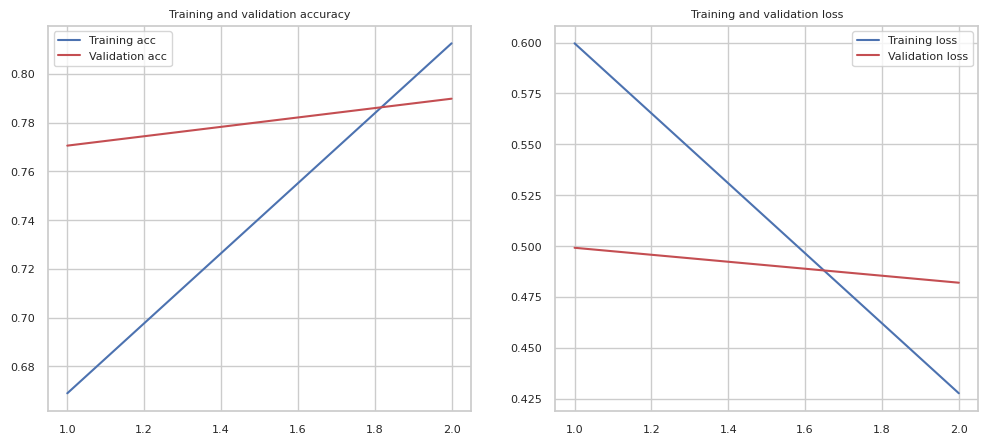

In [1424]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NB_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100

X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X.values)

vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values


# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)


model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.SpatialDropout1D(0.6))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 2

batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# RED CONVOLUCIONAL 1D

Tokens únicos:  11748
Epoch 1/3
161/161 [==============================] - 3s 20ms/step - loss: 0.6546 - accuracy: 0.6240 - val_loss: 0.5363 - val_accuracy: 0.7863
Epoch 2/3
161/161 [==============================] - 3s 21ms/step - loss: 0.3985 - accuracy: 0.8379 - val_loss: 0.4594 - val_accuracy: 0.7951
Epoch 3/3
60/60 [==============================] - 0s 4ms/step - loss: 0.5372 - accuracy: 0.7684
Test set
  Loss: 0.537
  Accuracy: 0.768
Training Accuracy: 0.9373
Testing Accuracy:  0.7684


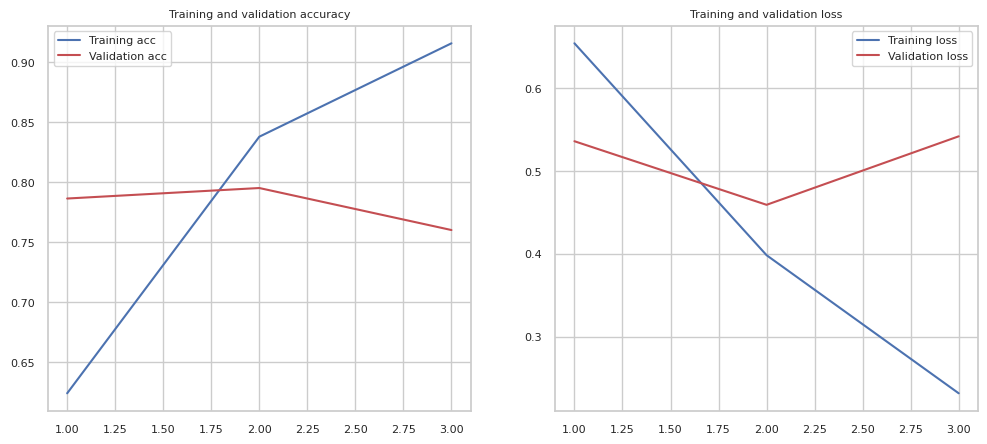

In [1385]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NB_WORDS = 50000

# Matriz de salida
EMBEDDING_DIM = 100
X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X.values)

vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

# Agrego unua red convolucional 1D
model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.Conv1D(100, 5, activation='sigmoid'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


epochs = 3
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# B. MLP Classifier

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.78      0.81      0.80      1107
           1       0.72      0.69      0.70       797

    accuracy                           0.76      1904
   macro avg       0.75      0.75      0.75      1904
weighted avg       0.76      0.76      0.76      1904

Matriz de confusión: 
 [[894 213]
 [248 549]]
ROC: 
 0.7482106000482841


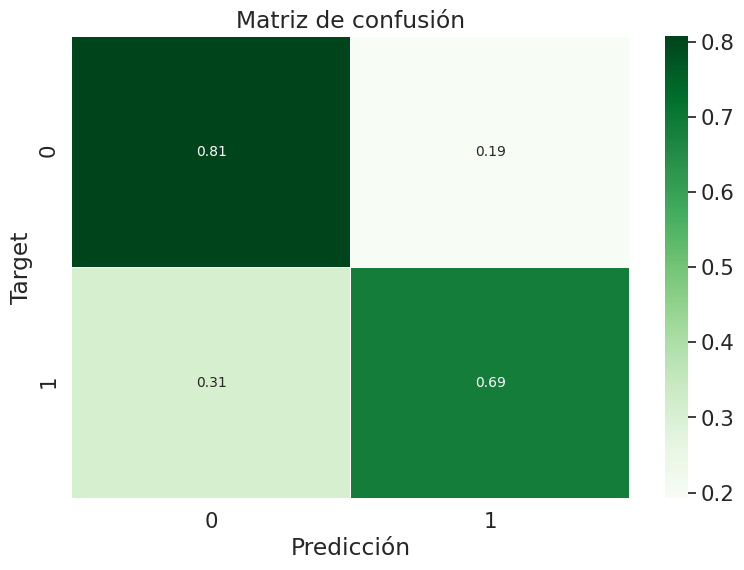

In [679]:
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

MLP = MLPClassifier(activation='logistic', solver='adam',random_state=1)

MLP.fit(X_train, y_train)

#Predicciones
y_pred = MLP.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)



# C. Light GBM Classifier

Accu: 0.773 (0.014521)
Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1107
           1       0.79      0.67      0.73       797

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.79      1904

Matriz de confusión: 
 [[968 139]
 [260 537]]
ROC: 
 0.7741060367525465


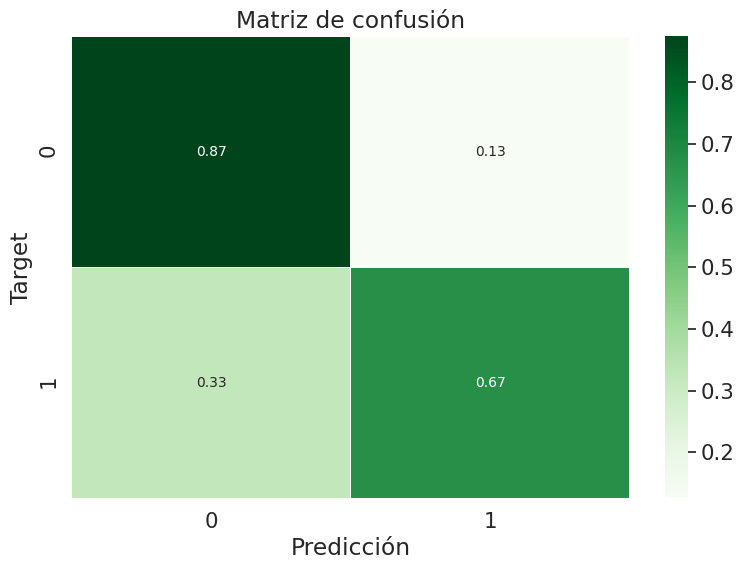

In [762]:
from lightgbm import LGBMClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


LGBM = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBM, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accu: %.3f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))

#Fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

#Predicciones
y_pred = LGBM.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)


# 2. XGBoost - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.69      0.90      0.78      1107
           1       0.75      0.44      0.56       797

    accuracy                           0.71      1904
   macro avg       0.72      0.67      0.67      1904
weighted avg       0.72      0.71      0.69      1904

Matriz de confusión: 
 [[991 116]
 [443 354]]
ROC: 
 0.6696889532676171


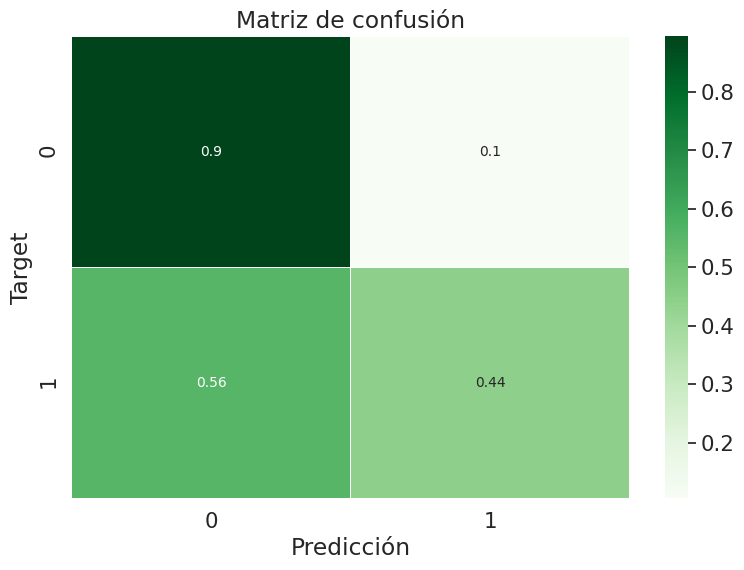

In [749]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1468
           1       0.83      0.64      0.72      1045

    accuracy                           0.79      2513
   macro avg       0.80      0.77      0.78      2513
weighted avg       0.80      0.79      0.79      2513

Matriz de confusión: 
 [[1332  136]
 [ 381  664]]
ROC: 
 0.7713818233967381


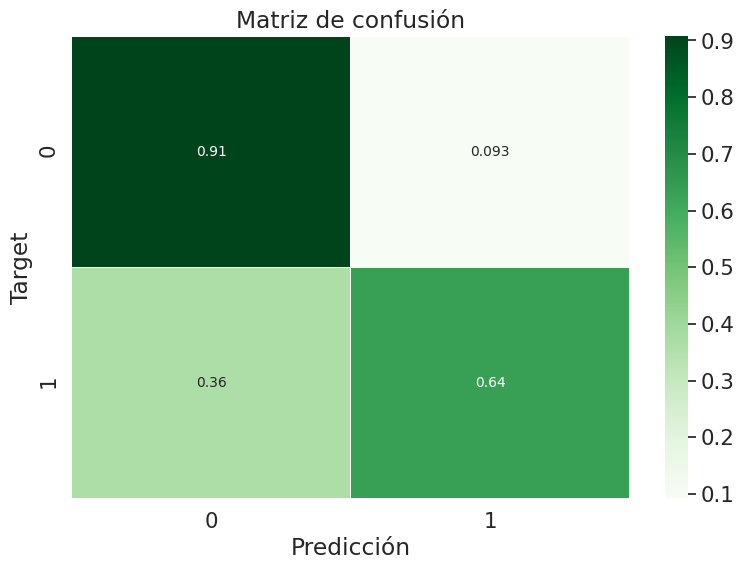

In [761]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators=500, max_depth=131, class_weight = 'balanced',
                             criterion='entropy', max_features='auto', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

#Features importances
#features = np.array(X.columns)
importances = RFC.feature_importances_

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''
print('')

# 4. Regresión Logística - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1091
           1       0.80      0.70      0.75       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

Matriz de confusión: 
 [[951 140]
 [241 572]]
ROC: 
 0.7876221979451692


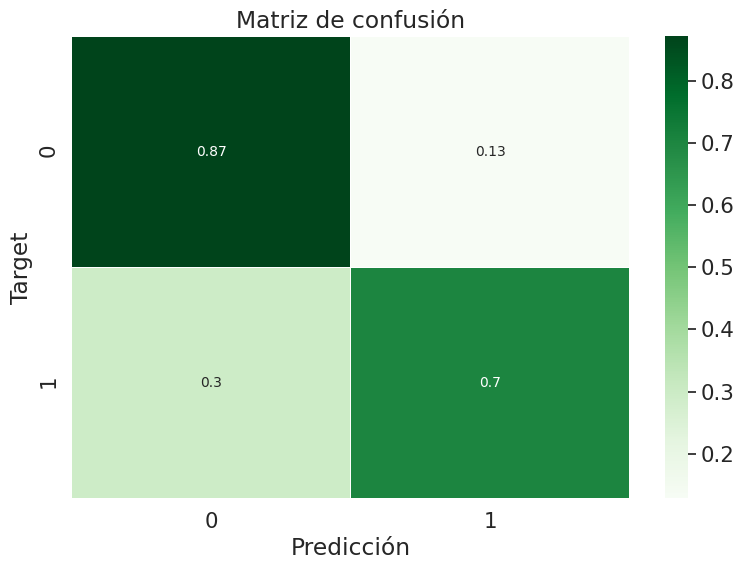

Weight?,Feature
+3.705,in
+3.463,fires
+3.428,hiroshima
+2.949,california
+2.874,train
+2.785,suicide
+2.487,fire
+2.436,bombing
+2.417,storm
+2.393,earthquake


In [1357]:
from sklearn.model_selection import cross_val_score

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento

LR = LogisticRegression(C=1.3, n_jobs=-1)
LR.fit(X_train, y_train)


#Métricas
y_pred = LR.predict(X_test)
mostrar_metricas(y_test, y_pred)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

# 5. KNN - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1091
           1       0.78      0.62      0.69       813

    accuracy                           0.77      1904
   macro avg       0.77      0.75      0.75      1904
weighted avg       0.77      0.77      0.76      1904

Matriz de confusión: 
 [[950 141]
 [306 507]]
ROC: 
 0.7471885030491001


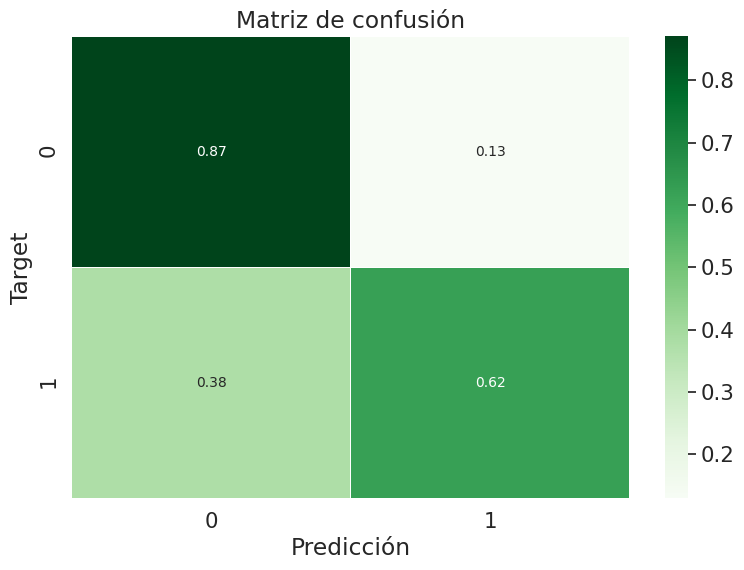

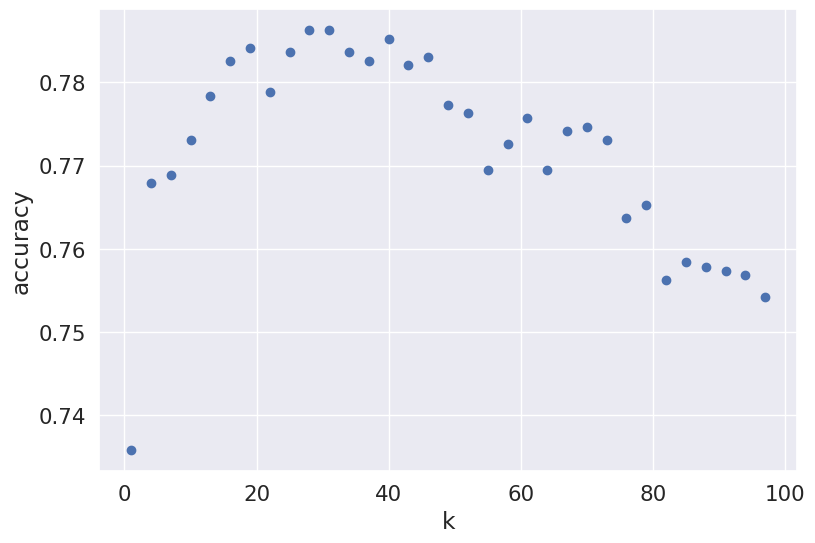

In [1358]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 79, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)


#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()



# 6. Multinomial NB - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1107
           1       0.86      0.62      0.72       797

    accuracy                           0.80      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.81      0.80      0.79      1904

Matriz de confusión: 
 [[1024   83]
 [ 302  495]]
ROC: 
 0.7730508149916295


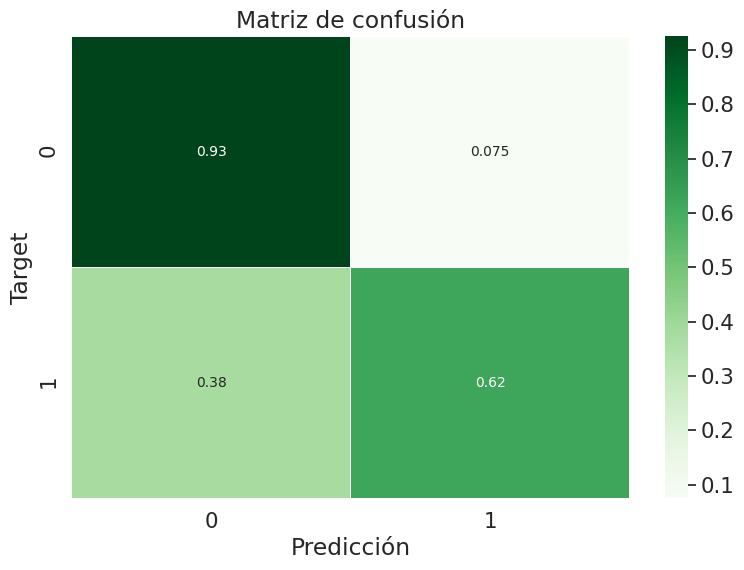

In [673]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)